##  Project 5 Vehicle Detection and Tracking


In [27]:
import numpy as np
import cv2, glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pickle
from tool_functions import *
#%matplotlib qt
%matplotlib inline


In [28]:
### TODO: Tweak these parameters and see how the results change.
#color_space = 'RGB' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
#color_space = 'HSV'
color_space = 'HLS'

orient = 9  # HOG orientations

#pix_per_cell = 8 # HOG pixels per cell
# making it 4 to have more rect in find_cars 
pix_per_cell = 4 # HOG pixels per cell

cell_per_block = 2 # HOG cells per block

hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"
#spatial_size = (16, 16) # Spatial binning dimensions
spatial_size = (16, 16) # Spatial binning dimensions

#hist_bins = 16    # Number of histogram bins
hist_bins = 16    # Number of histogram bins

spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off
y_start_stop = [None, None] # Min and max in y to search in slide_window()

# global variables:
X_scaler = None


In [30]:
from pathlib import Path

clf_file = Path("save/clf.pickle")
scaler_file = Path("save/x_scaler.pickle")
if clf_file.is_file() & scaler_file.is_file():
    print(my_file,  "exist! Don't train classifier, just load it.")
    with open('save/clf.pickle', 'rb') as f:
        clf2 = pickle.load(f)
        print(clf2)    
    with open('save/x_scaler.pickle', 'rb') as f:
        global X_scaler
        X_scaler = pickle.load(f)
else:
    print(my_file,  "One or more model files not exist, start training classifier...")
    clf2 = train_classifier()
    


save/clf.pickle One or more model files not exist, start train classifier...
cars size :  400
notcars size :  400
elapsed_time :  0.03473329544067383


/home/pachinko/anaconda3/envs/py35/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


car_features shape:,  400
X:,  (800, 25116)  X_scaler:  StandardScaler(copy=True, with_mean=True, with_std=True)
Using: 9 orientations 4 pixels per cell and 2 cells per block
Feature vector length: 25116
0.48 Seconds to train SVC...
Test Accuracy of SVC =  0.9812


elapsed_time :  0.03559708595275879


/home/pachinko/anaconda3/envs/py35/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


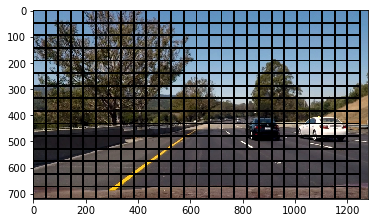

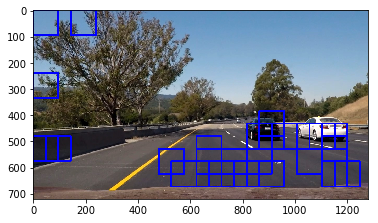

elapsed_time :  6.238020181655884
cell passed.


In [31]:
import numpy as np
import cv2, glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pickle
from tool_functions import *
#%matplotlib qt
%matplotlib inline

start_time = time.time()

image = mpimg.imread('test_images/test6.jpg')
draw_image = np.copy(image)

# Uncomment the following line if you extracted training
# data from .png images (scaled 0 to 1 by mpimg) and the
# image you are searching is a .jpg (scaled 0 to 255)
image = image.astype(np.float32)/255

windows = slide_window(image, x_start_stop=[None, None], y_start_stop=y_start_stop, 
                    xy_window=(96, 96), xy_overlap=(0.5, 0.5))
# windows = slide_window(image, x_start_stop=[None, None], y_start_stop=y_start_stop, 
#                     xy_window=(48, 48), xy_overlap=(0.5, 0.5))

elapsed_time = time.time() - start_time
print('elapsed_time : ', elapsed_time )

hot_windows = search_windows(image, windows, clf2, X_scaler, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel
                        ,spatial_feat=spatial_feat, hist_feat=hist_feat, hog_feat=hog_feat
                            )

window_img = draw_boxes(image, windows, color=(0, 0, 255), thick=6)                    
plt.imshow(window_img)
plt.show()

window_img = draw_boxes(draw_image, hot_windows, color=(0, 0, 255), thick=6)                    
plt.imshow(window_img)
plt.show()

elapsed_time = time.time() - start_time
print('elapsed_time : ', elapsed_time )

print('cell passed.')

images :  ['test_images/test2.jpg', 'test_images/test5.jpg', 'test_images/test6.jpg', 'test_images/test1.jpg', 'test_images/test3.jpg', 'test_images/test4.jpg']


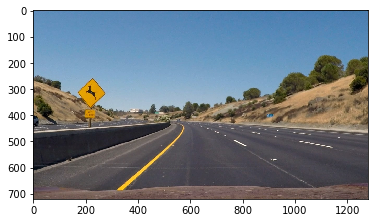

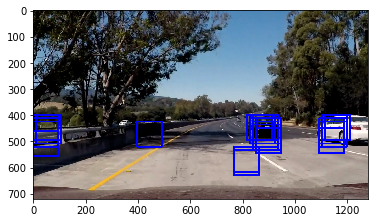

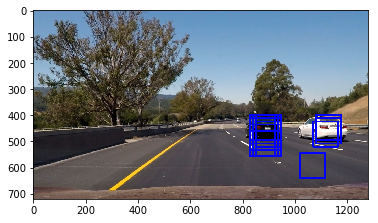

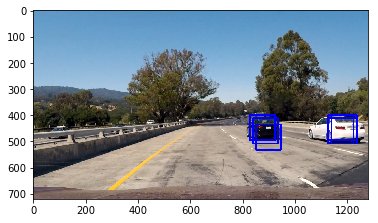

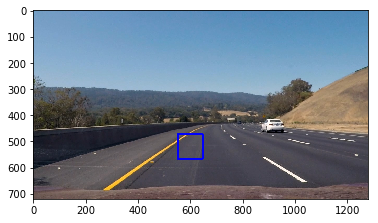

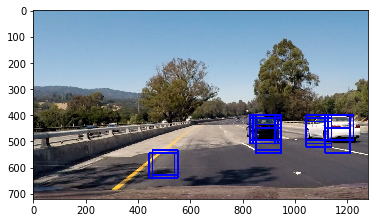

cell passed.


In [55]:
# test on findcars.
ystart = 400
ystop = 656
scale = 1.5

filenames = glob.glob('test_images/*.jpg')
print('images : ', filenames)
for filename in filenames:
    img = mpimg.imread(filename)
    out_img, rect = find_cars(img, ystart, ystop, scale, clf2, X_scaler, orient, 
                              pix_per_cell, cell_per_block, spatial_size, hist_bins)

    plt.imshow(out_img)
    plt.show()
print('cell passed.')

images :  ['test_images/test2.jpg', 'test_images/test5.jpg', 'test_images/test6.jpg', 'test_images/test1.jpg', 'test_images/test3.jpg', 'test_images/test4.jpg']
bbox_list len:  0
0 cars found


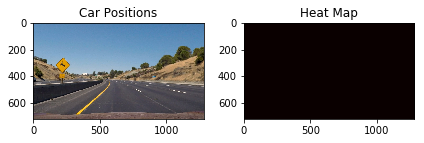

bbox_list len:  26
3 cars found


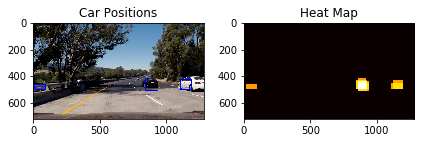

bbox_list len:  17
1 cars found


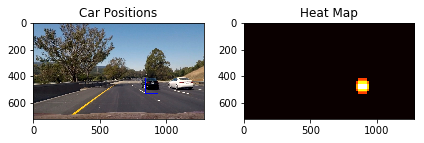

bbox_list len:  7
0 cars found


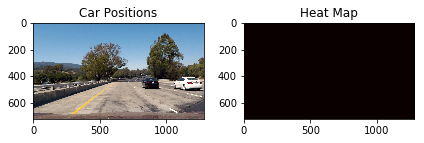

bbox_list len:  1
0 cars found


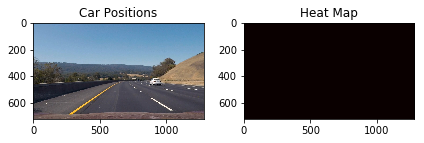

bbox_list len:  17
2 cars found


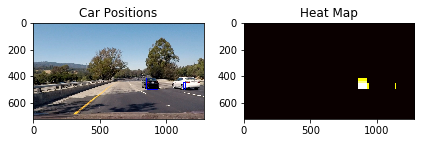

cell passed.


In [56]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
from scipy.ndimage.measurements import label

def add_heat(heatmap, bbox_list, debug = False):
    if debug:
        print('bbox_list len: ', len(bbox_list) )
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap


def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap


def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img


def makeheatmap(img, rect, heatmap_threshold, debug = False):
    heat = np.zeros_like(img[:,:,0]).astype(np.float)
    heat = add_heat(heat, rect, debug)

    heat = apply_threshold(heat, heatmap_threshold)
    labels = label(heat)
    if debug:
        print(labels[1], 'cars found')
#         print('labels: ', labels[0])
#         plt.imshow(labels[0], cmap='gray')

    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)

    # Draw bounding boxes on a copy of the image
    draw_img = draw_labeled_bboxes(np.copy(img), labels)

    if debug:
        # Display the image
#         plt.imshow(draw_img)

        fig = plt.figure()
        plt.subplot(121)
        plt.imshow(draw_img)
        plt.title('Car Positions')
        plt.subplot(122)
        plt.imshow(heatmap, cmap='hot')
        plt.title('Heat Map')
        fig.tight_layout()
        plt.show()
        
    return draw_img

    
filenames = glob.glob('test_images/*.jpg')
print('images : ', filenames)
for filename in filenames:
    img = mpimg.imread(filename)
    out_img, rect = find_cars(img, ystart, ystop, scale, clf2, X_scaler, orient, 
                              pix_per_cell, cell_per_block, spatial_size, hist_bins)

    heatmap_threshold = 5
    heat_img = makeheatmap(img, rect, heatmap_threshold, True)
#     plt.imshow(heat_img)
#     plt.show()

print('cell passed.')
    

In [57]:

#interrupt


In [ ]:
def process_one_image(img, debug = False):
    out_img, rect = find_cars(img, ystart, ystop, scale, clf2, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
#     heatmap_threshold = 2
    heat_img = makeheatmap(img, rect, heatmap_threshold, debug)

    return heat_img

def process_image(image, debug = False):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image where lines are drawn on lanes)
    
    # turn on debug to produce some image, for debugging or the writeups.
    debug = False
    debug = True
    return process_one_image(image, debug)




bbox_list len:  4
0 cars found


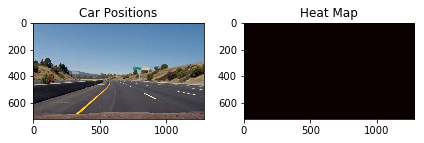

[MoviePy] >>>> Building video test_videos_output/project-output.mp4
[MoviePy] Writing video test_videos_output/project-output.mp4





  0%|          | 0/1261 [00:00<?, ?it/s]

bbox_list len:  4
0 cars found


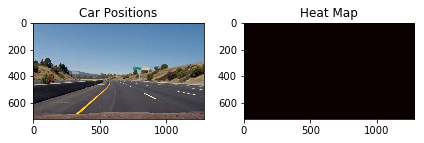




  0%|          | 1/1261 [00:02<50:12,  2.39s/it]

bbox_list len:  0
0 cars found


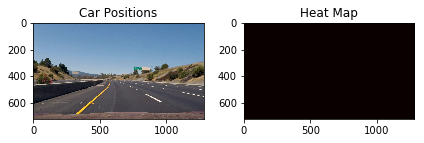




  0%|          | 2/1261 [00:04<49:26,  2.36s/it]

bbox_list len:  9
1 cars found


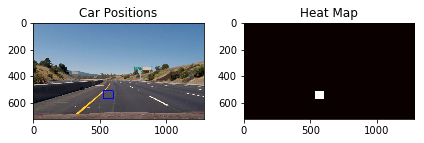




  0%|          | 3/1261 [00:07<50:37,  2.41s/it]

bbox_list len:  2
0 cars found


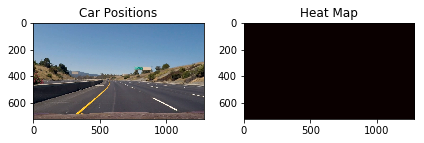




  0%|          | 4/1261 [00:09<48:41,  2.32s/it]

bbox_list len:  2
0 cars found


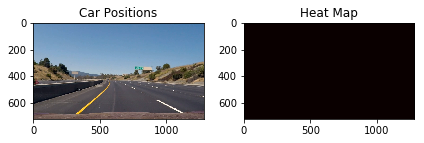




  0%|          | 5/1261 [00:11<48:21,  2.31s/it]

bbox_list len:  2
0 cars found


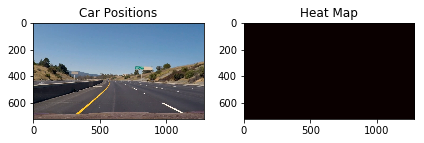




  0%|          | 6/1261 [00:13<45:55,  2.20s/it]

bbox_list len:  1
0 cars found


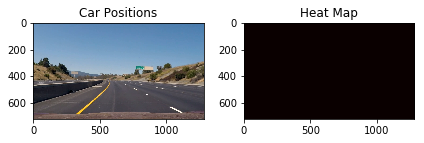




  1%|          | 7/1261 [00:15<45:11,  2.16s/it]

bbox_list len:  8
0 cars found


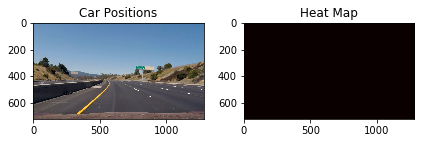




  1%|          | 8/1261 [00:18<52:02,  2.49s/it]

bbox_list len:  11
1 cars found


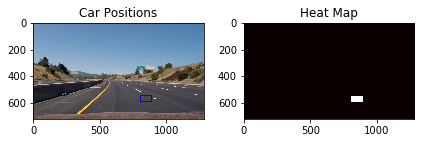




  1%|          | 9/1261 [00:20<49:36,  2.38s/it]

bbox_list len:  9
1 cars found


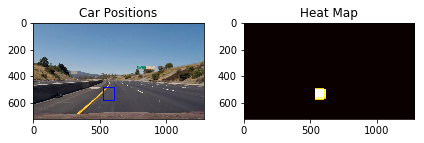




  1%|          | 10/1261 [00:23<47:40,  2.29s/it]

bbox_list len:  11
1 cars found


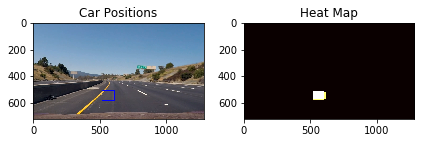




  1%|          | 11/1261 [00:25<46:15,  2.22s/it]

bbox_list len:  9
1 cars found


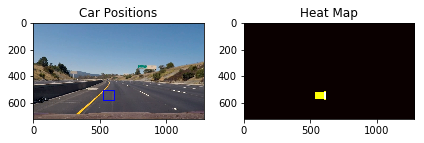




  1%|          | 12/1261 [00:29<59:42,  2.87s/it]

bbox_list len:  15
1 cars found


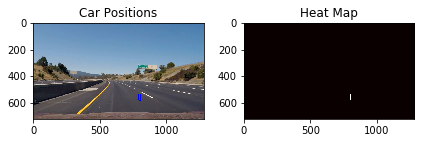




  1%|          | 13/1261 [00:32<57:53,  2.78s/it]

bbox_list len:  8
0 cars found


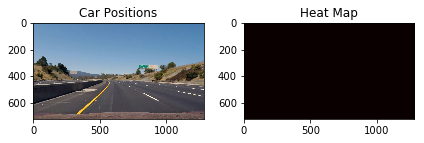




  1%|          | 14/1261 [00:34<55:40,  2.68s/it]

bbox_list len:  10
1 cars found


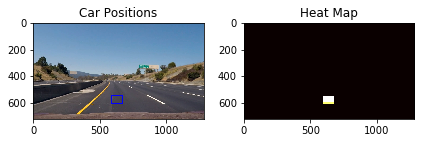




  1%|          | 15/1261 [00:37<57:51,  2.79s/it]

bbox_list len:  1
0 cars found


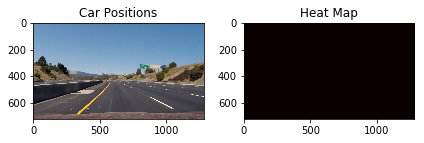




  1%|▏         | 16/1261 [00:40<58:15,  2.81s/it]

bbox_list len:  6
0 cars found


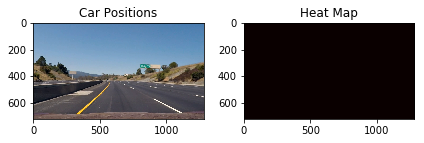




  1%|▏         | 17/1261 [00:42<56:24,  2.72s/it]

bbox_list len:  11
1 cars found


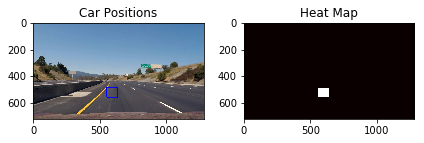




  1%|▏         | 18/1261 [00:45<52:45,  2.55s/it]

bbox_list len:  6
0 cars found


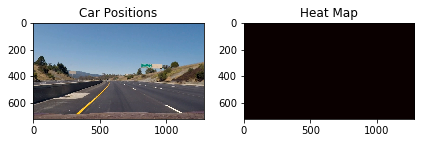




  2%|▏         | 19/1261 [00:47<49:37,  2.40s/it]

bbox_list len:  15
2 cars found


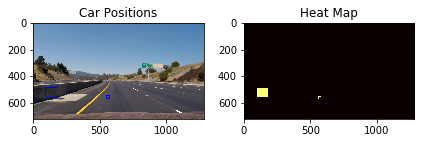




  2%|▏         | 20/1261 [00:49<47:37,  2.30s/it]

bbox_list len:  14
1 cars found


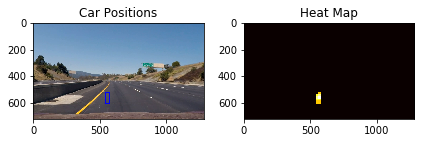




  2%|▏         | 21/1261 [00:51<46:15,  2.24s/it]

bbox_list len:  4
0 cars found


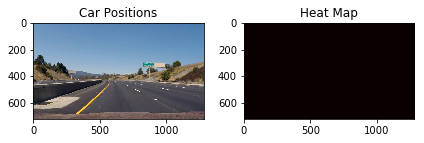




  2%|▏         | 22/1261 [00:53<44:29,  2.15s/it]

bbox_list len:  5
0 cars found


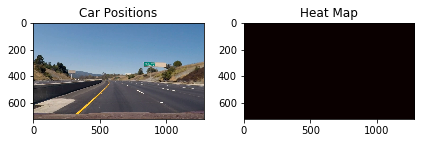




  2%|▏         | 23/1261 [00:55<42:48,  2.07s/it]

bbox_list len:  7
0 cars found


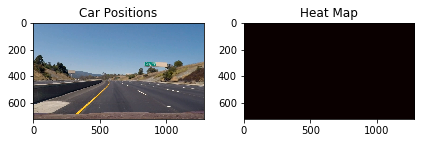




  2%|▏         | 24/1261 [00:57<42:47,  2.08s/it]

bbox_list len:  0
0 cars found


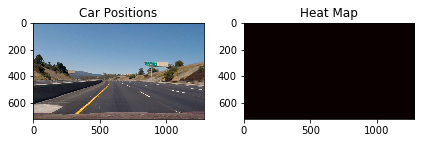




  2%|▏         | 25/1261 [00:59<42:40,  2.07s/it]

bbox_list len:  3
0 cars found


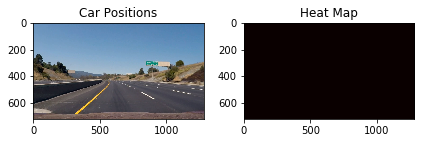




  2%|▏         | 26/1261 [01:01<42:24,  2.06s/it]

bbox_list len:  2
0 cars found


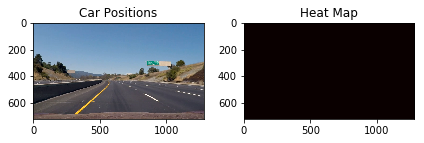




  2%|▏         | 27/1261 [01:03<41:30,  2.02s/it]

bbox_list len:  6
0 cars found


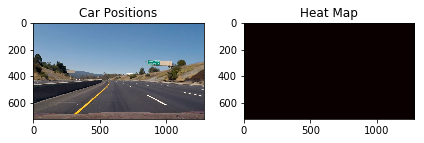




  2%|▏         | 28/1261 [01:05<40:55,  1.99s/it]

bbox_list len:  9
0 cars found


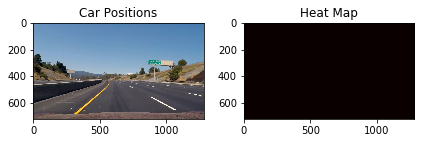




  2%|▏         | 29/1261 [01:07<40:33,  1.98s/it]

bbox_list len:  7
0 cars found


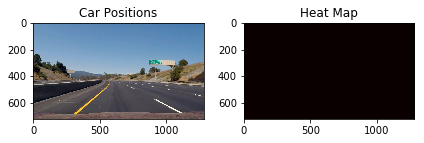




  2%|▏         | 30/1261 [01:08<39:55,  1.95s/it]

bbox_list len:  7
0 cars found


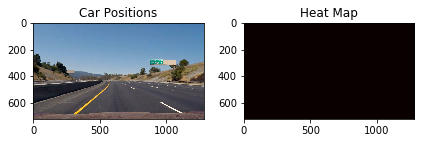




  2%|▏         | 31/1261 [01:10<39:55,  1.95s/it]

bbox_list len:  14
1 cars found


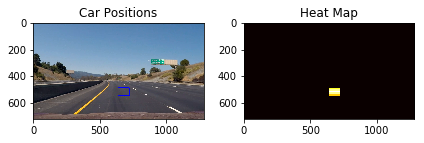




  3%|▎         | 32/1261 [01:12<39:43,  1.94s/it]

bbox_list len:  18
1 cars found


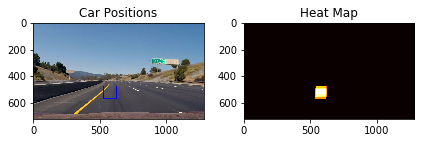




  3%|▎         | 33/1261 [01:14<39:28,  1.93s/it]

bbox_list len:  9
0 cars found


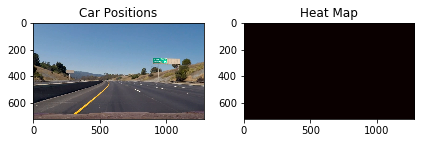




  3%|▎         | 34/1261 [01:16<39:18,  1.92s/it]

bbox_list len:  3
0 cars found


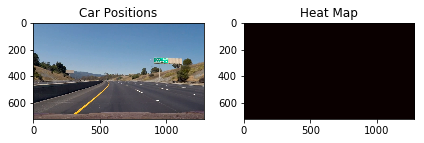




  3%|▎         | 35/1261 [01:18<39:57,  1.96s/it]

bbox_list len:  2
0 cars found


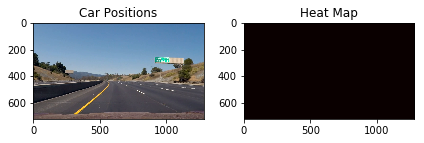




  3%|▎         | 36/1261 [01:20<40:39,  1.99s/it]

bbox_list len:  3
0 cars found


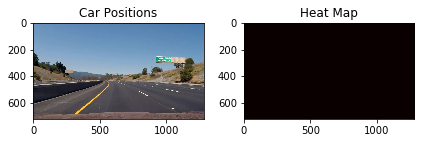




  3%|▎         | 37/1261 [01:22<40:13,  1.97s/it]

bbox_list len:  6
0 cars found


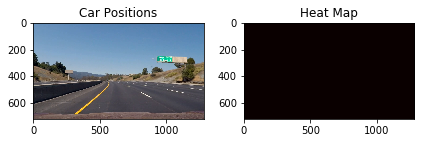




  3%|▎         | 38/1261 [01:24<40:47,  2.00s/it]

bbox_list len:  5
0 cars found


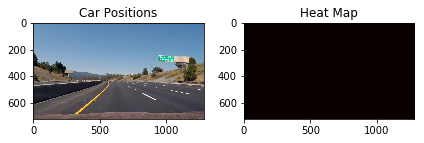




  3%|▎         | 39/1261 [01:26<40:56,  2.01s/it]

bbox_list len:  19
2 cars found


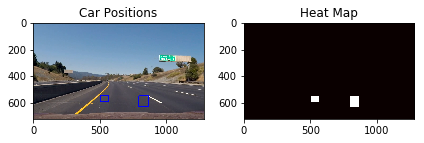




  3%|▎         | 40/1261 [01:28<40:57,  2.01s/it]

bbox_list len:  8
1 cars found


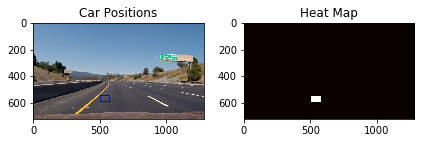




  3%|▎         | 41/1261 [01:30<41:51,  2.06s/it]

bbox_list len:  3
0 cars found


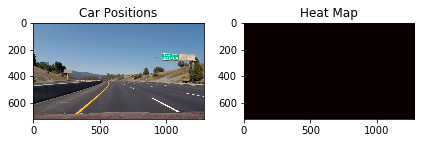




  3%|▎         | 42/1261 [01:32<41:11,  2.03s/it]

bbox_list len:  1
0 cars found


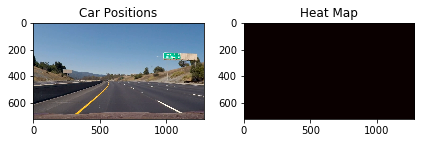




  3%|▎         | 43/1261 [01:34<40:24,  1.99s/it]

bbox_list len:  5
0 cars found


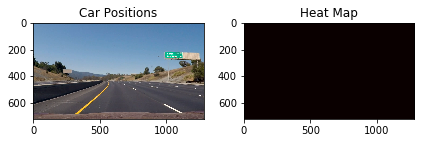




  3%|▎         | 44/1261 [01:36<39:48,  1.96s/it]

bbox_list len:  2
0 cars found


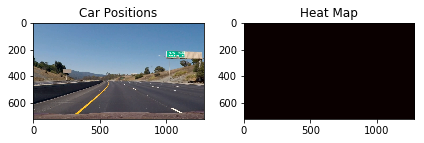




  4%|▎         | 45/1261 [01:38<39:13,  1.94s/it]

bbox_list len:  3
0 cars found


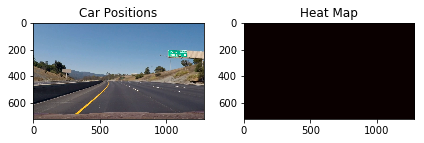




  4%|▎         | 46/1261 [01:40<39:35,  1.96s/it]

bbox_list len:  2
0 cars found


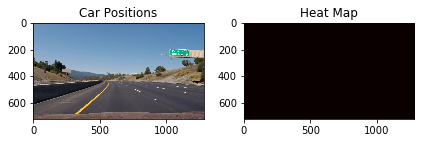




  4%|▎         | 47/1261 [01:42<40:29,  2.00s/it]

bbox_list len:  1
0 cars found


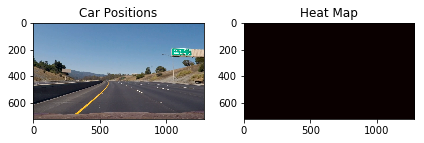




  4%|▍         | 48/1261 [01:44<40:30,  2.00s/it]

bbox_list len:  1
0 cars found


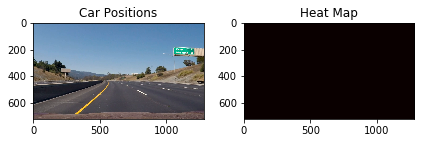




  4%|▍         | 49/1261 [01:46<41:18,  2.05s/it]

bbox_list len:  3
0 cars found


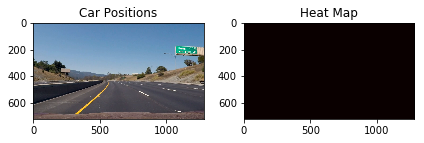




  4%|▍         | 50/1261 [01:48<41:22,  2.05s/it]

bbox_list len:  7
0 cars found


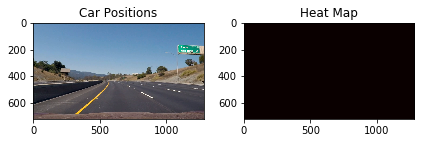




  4%|▍         | 51/1261 [01:50<41:14,  2.04s/it]

bbox_list len:  2
0 cars found


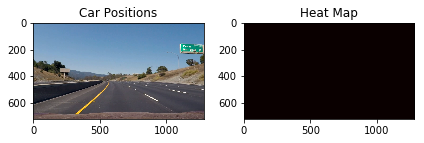




  4%|▍         | 52/1261 [01:52<40:26,  2.01s/it]

bbox_list len:  5
0 cars found


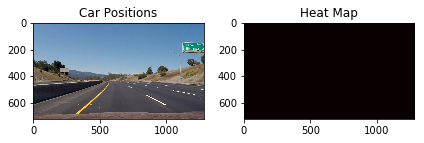




  4%|▍         | 53/1261 [01:54<40:57,  2.03s/it]

bbox_list len:  4
0 cars found


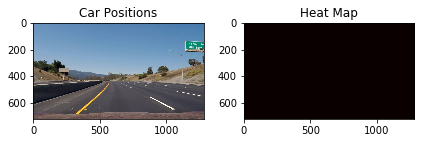




  4%|▍         | 54/1261 [01:57<41:24,  2.06s/it]

bbox_list len:  14
1 cars found


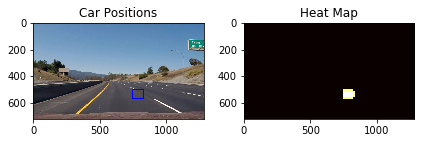




  4%|▍         | 55/1261 [01:59<41:11,  2.05s/it]

bbox_list len:  2
0 cars found


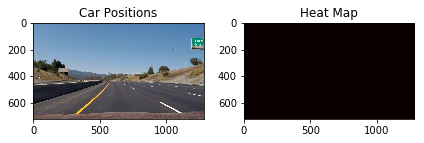




  4%|▍         | 56/1261 [02:01<42:23,  2.11s/it]

bbox_list len:  7
0 cars found


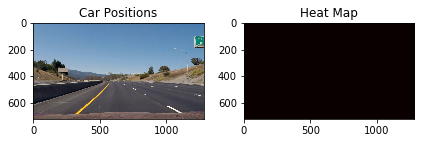




  5%|▍         | 57/1261 [02:03<43:05,  2.15s/it]

bbox_list len:  5
0 cars found


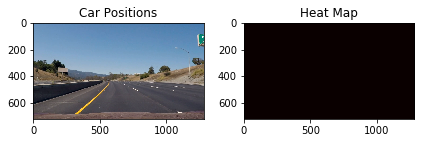




  5%|▍         | 58/1261 [02:05<43:33,  2.17s/it]

bbox_list len:  5
0 cars found


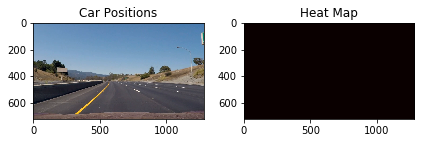




  5%|▍         | 59/1261 [02:08<45:02,  2.25s/it]

bbox_list len:  10
1 cars found


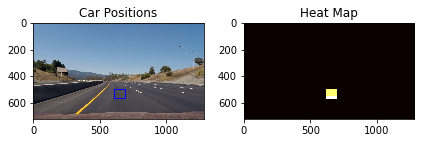




  5%|▍         | 60/1261 [02:10<47:31,  2.37s/it]

bbox_list len:  5
0 cars found


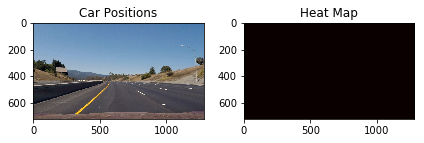




  5%|▍         | 61/1261 [02:13<45:55,  2.30s/it]

bbox_list len:  23
3 cars found


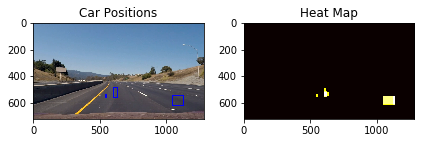




  5%|▍         | 62/1261 [02:15<44:23,  2.22s/it]

bbox_list len:  11
1 cars found


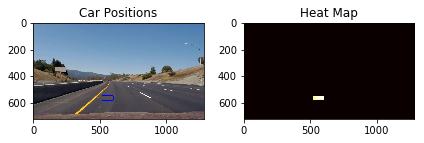




  5%|▍         | 63/1261 [02:17<42:44,  2.14s/it]

bbox_list len:  8
0 cars found


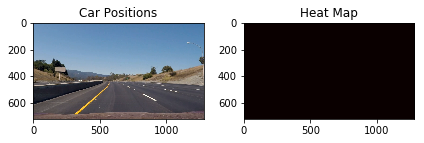




  5%|▌         | 64/1261 [02:19<42:14,  2.12s/it]

bbox_list len:  2
0 cars found


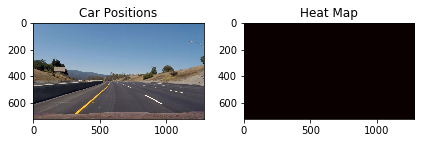




  5%|▌         | 65/1261 [02:21<41:37,  2.09s/it]

bbox_list len:  6
1 cars found


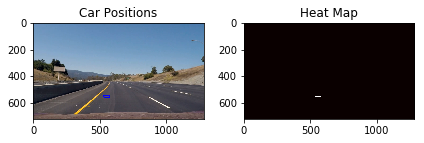




  5%|▌         | 66/1261 [02:23<42:20,  2.13s/it]

bbox_list len:  12
0 cars found


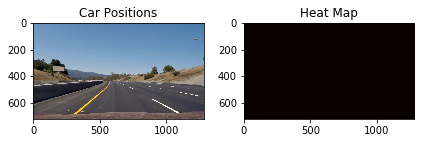




  5%|▌         | 67/1261 [02:25<42:37,  2.14s/it]

bbox_list len:  6
0 cars found


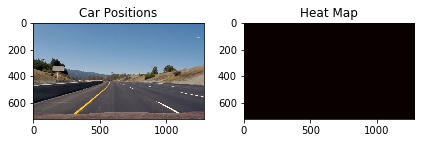




  5%|▌         | 68/1261 [02:28<45:13,  2.27s/it]

bbox_list len:  13
1 cars found


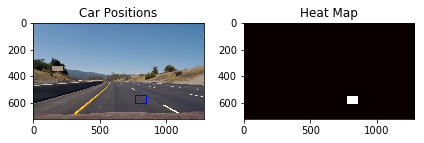




  5%|▌         | 69/1261 [02:30<45:25,  2.29s/it]

bbox_list len:  3
0 cars found


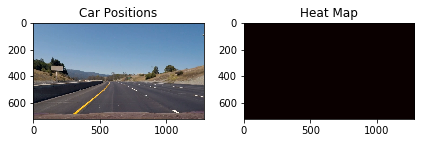




  6%|▌         | 70/1261 [02:32<44:24,  2.24s/it]

bbox_list len:  8
0 cars found


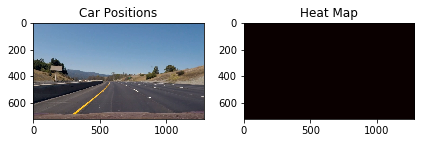




  6%|▌         | 71/1261 [02:34<44:04,  2.22s/it]

bbox_list len:  8
0 cars found


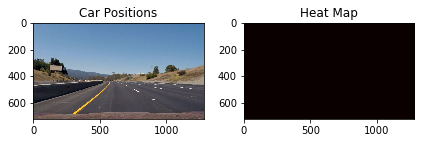




  6%|▌         | 72/1261 [02:36<42:20,  2.14s/it]

bbox_list len:  3
0 cars found


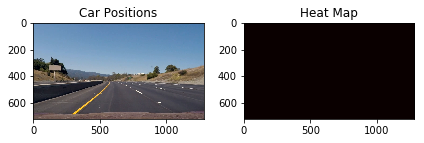




  6%|▌         | 73/1261 [02:39<43:24,  2.19s/it]

bbox_list len:  2
0 cars found


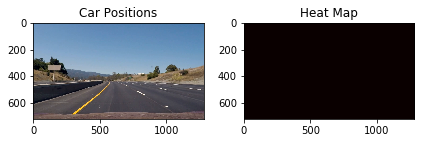




  6%|▌         | 74/1261 [02:41<43:41,  2.21s/it]

bbox_list len:  3
0 cars found


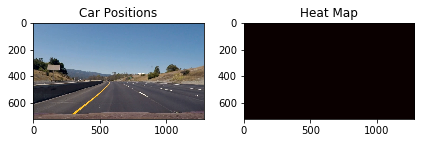




  6%|▌         | 75/1261 [02:43<43:06,  2.18s/it]

bbox_list len:  14
0 cars found


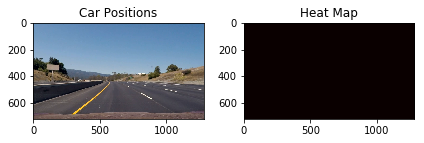




  6%|▌         | 76/1261 [02:45<44:41,  2.26s/it]

bbox_list len:  2
0 cars found


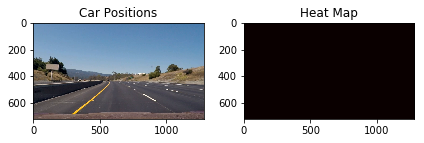




  6%|▌         | 77/1261 [02:47<44:05,  2.23s/it]

bbox_list len:  9
0 cars found


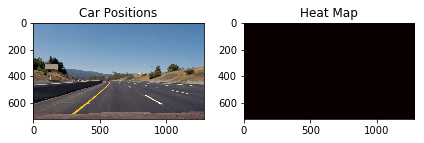




  6%|▌         | 78/1261 [02:50<42:49,  2.17s/it]

bbox_list len:  12
0 cars found


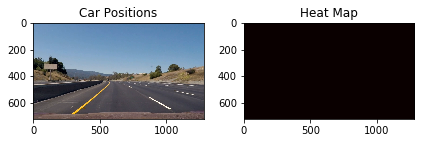




  6%|▋         | 79/1261 [02:52<43:38,  2.22s/it]

bbox_list len:  4
0 cars found


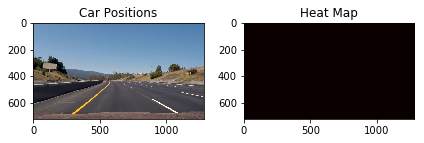




  6%|▋         | 80/1261 [02:54<42:26,  2.16s/it]

bbox_list len:  7
0 cars found


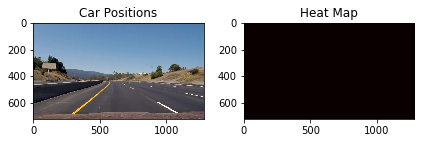




  6%|▋         | 81/1261 [02:56<41:40,  2.12s/it]

bbox_list len:  3
0 cars found


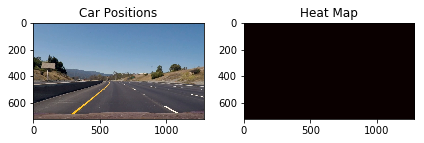




  7%|▋         | 82/1261 [02:58<41:39,  2.12s/it]

bbox_list len:  5
0 cars found


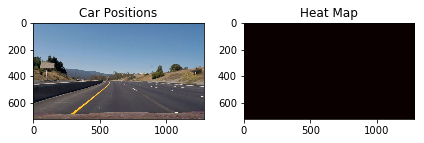




  7%|▋         | 83/1261 [03:00<42:01,  2.14s/it]

bbox_list len:  4
0 cars found


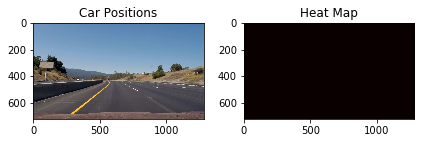




  7%|▋         | 84/1261 [03:02<41:12,  2.10s/it]

bbox_list len:  6
0 cars found


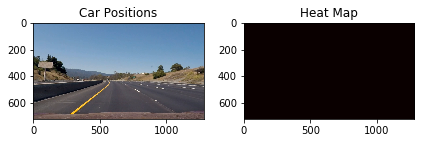




  7%|▋         | 85/1261 [03:04<40:53,  2.09s/it]

bbox_list len:  12
1 cars found


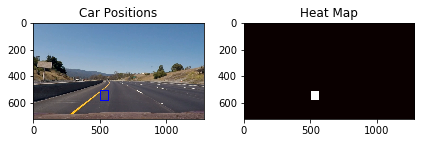




  7%|▋         | 86/1261 [03:06<40:19,  2.06s/it]

bbox_list len:  11
1 cars found


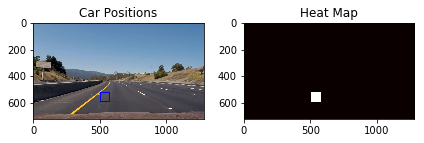




  7%|▋         | 87/1261 [03:08<39:41,  2.03s/it]

bbox_list len:  4
0 cars found


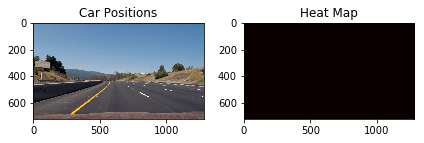




  7%|▋         | 88/1261 [03:10<39:46,  2.03s/it]

bbox_list len:  4
0 cars found


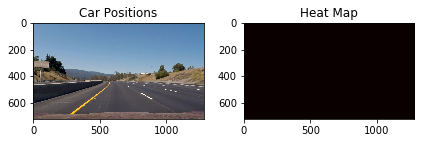




  7%|▋         | 89/1261 [03:12<39:51,  2.04s/it]

bbox_list len:  5
0 cars found


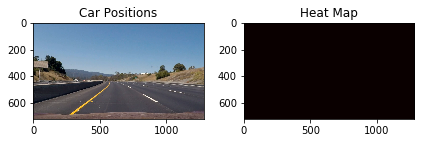




  7%|▋         | 90/1261 [03:14<40:03,  2.05s/it]

bbox_list len:  1
0 cars found


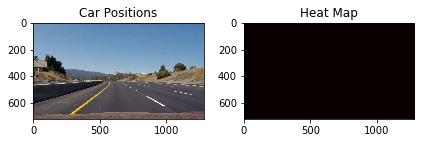




  7%|▋         | 91/1261 [03:17<41:14,  2.11s/it]

bbox_list len:  6
0 cars found


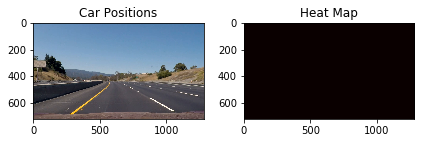




  7%|▋         | 92/1261 [03:19<41:11,  2.11s/it]

bbox_list len:  4
0 cars found


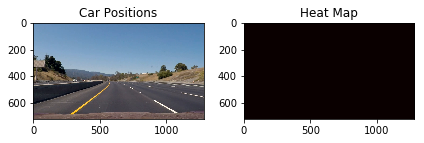




  7%|▋         | 93/1261 [03:21<41:11,  2.12s/it]

bbox_list len:  4
0 cars found


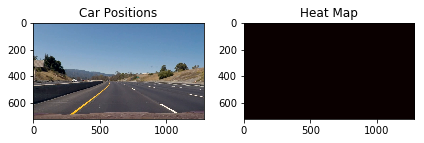




  7%|▋         | 94/1261 [03:23<43:23,  2.23s/it]

bbox_list len:  4
0 cars found


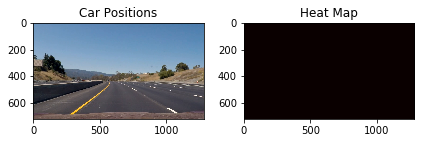




  8%|▊         | 95/1261 [03:26<42:43,  2.20s/it]

bbox_list len:  4
0 cars found


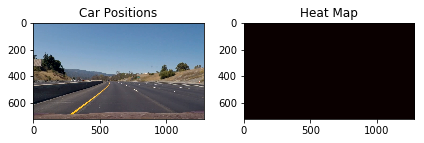




  8%|▊         | 96/1261 [03:28<42:03,  2.17s/it]

bbox_list len:  2
0 cars found


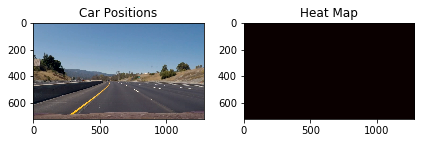




  8%|▊         | 97/1261 [03:30<41:50,  2.16s/it]

bbox_list len:  2
0 cars found


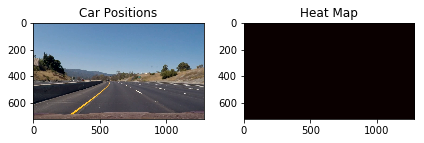




  8%|▊         | 98/1261 [03:32<41:04,  2.12s/it]

bbox_list len:  9
0 cars found


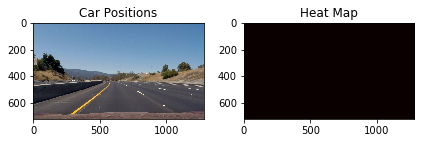




  8%|▊         | 99/1261 [03:35<45:23,  2.34s/it]

bbox_list len:  2
0 cars found


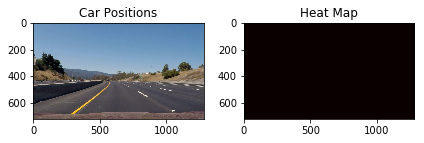




  8%|▊         | 100/1261 [03:37<47:01,  2.43s/it]

bbox_list len:  3
0 cars found


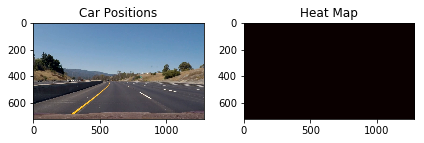




  8%|▊         | 101/1261 [03:40<50:36,  2.62s/it]

bbox_list len:  3
0 cars found


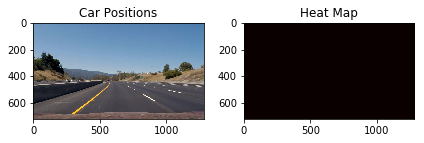




  8%|▊         | 102/1261 [03:42<47:44,  2.47s/it]

bbox_list len:  9
0 cars found


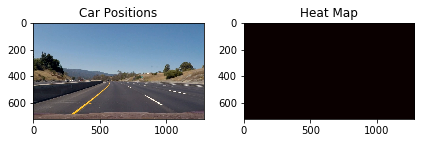




  8%|▊         | 103/1261 [03:45<45:52,  2.38s/it]

bbox_list len:  4
0 cars found


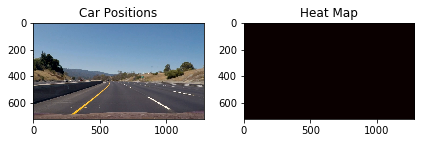




  8%|▊         | 104/1261 [03:47<45:11,  2.34s/it]

bbox_list len:  4
0 cars found


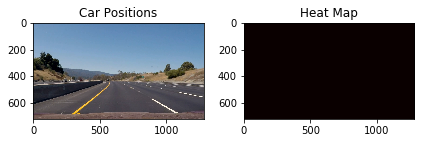




  8%|▊         | 105/1261 [03:50<49:22,  2.56s/it]

bbox_list len:  6
1 cars found


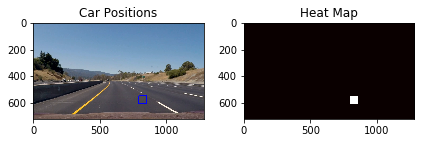




  8%|▊         | 106/1261 [03:53<52:01,  2.70s/it]

bbox_list len:  7
1 cars found


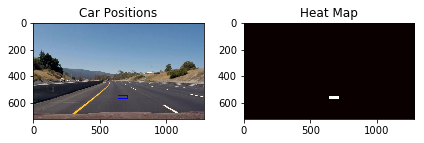




  8%|▊         | 107/1261 [03:55<50:14,  2.61s/it]

bbox_list len:  6
0 cars found


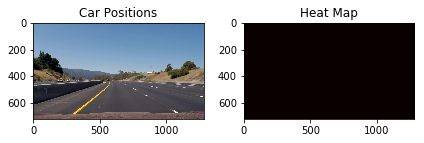




  9%|▊         | 108/1261 [03:58<47:31,  2.47s/it]

bbox_list len:  9
0 cars found


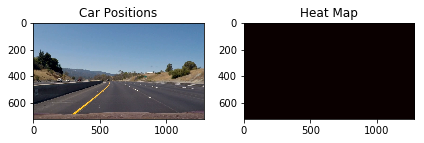




  9%|▊         | 109/1261 [04:00<46:00,  2.40s/it]

bbox_list len:  7
0 cars found


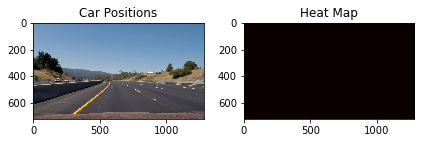




  9%|▊         | 110/1261 [04:02<44:49,  2.34s/it]

bbox_list len:  8
1 cars found


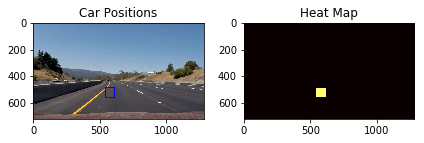




  9%|▉         | 111/1261 [04:04<43:30,  2.27s/it]

bbox_list len:  5
0 cars found


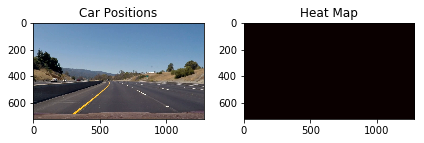




  9%|▉         | 112/1261 [04:06<43:08,  2.25s/it]

bbox_list len:  6
0 cars found


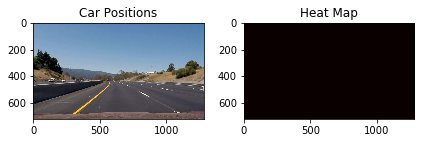




  9%|▉         | 113/1261 [04:09<44:24,  2.32s/it]

bbox_list len:  3
0 cars found


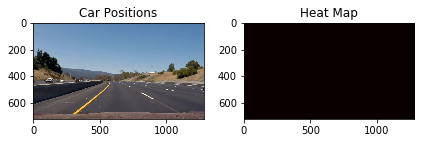




  9%|▉         | 114/1261 [04:11<42:36,  2.23s/it]

bbox_list len:  3
0 cars found


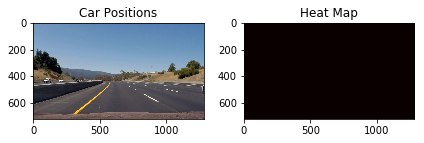




  9%|▉         | 115/1261 [04:13<41:12,  2.16s/it]

bbox_list len:  1
0 cars found


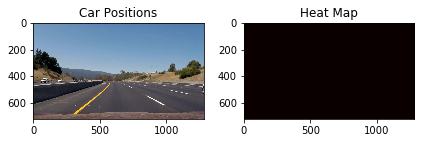




  9%|▉         | 116/1261 [04:15<42:17,  2.22s/it]

bbox_list len:  7
0 cars found


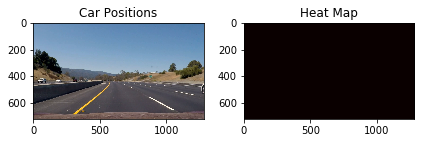




  9%|▉         | 117/1261 [04:18<46:09,  2.42s/it]

bbox_list len:  2
0 cars found


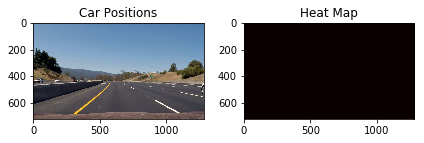




  9%|▉         | 118/1261 [04:21<47:47,  2.51s/it]

bbox_list len:  8
0 cars found


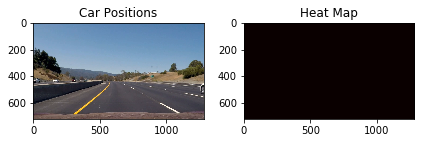




  9%|▉         | 119/1261 [04:24<55:00,  2.89s/it]

In [ ]:
# make sure the output folder exist.
import os
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

outputdir = 'test_videos_output'
if not os.path.exists(outputdir):
    os.makedirs(outputdir)
    
white_output = outputdir + '/project-output.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("project_video.mp4")#.subclip(33, 37)
#clip1 = VideoFileClip("project_video.mp4").subclip(39,43)
#clip1 = VideoFileClip("project_video.mp4")

#clip1 = VideoFileClip("challenge_video.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

